## Load Libraries

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop,Adam
import keras

## Load Dataset

In [3]:
data = pd.read_json("/content/Dataset.json", lines=True)

In [4]:
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [5]:
data['text'] = data['headline']+' '+data['short_description']

In [6]:
data['text']

0         There Were 2 Mass Shootings In Texas Last Week...
1         Will Smith Joins Diplo And Nicky Jam For The 2...
2         Hugh Grant Marries For The First Time At Age 5...
3         Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4         Julianna Margulies Uses Donald Trump Poop Bags...
                                ...                        
200848    RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849    Maria Sharapova Stunned By Victoria Azarenka I...
200850    Giants Over Patriots, Jets Over Colts Among  M...
200851    Aldon Smith Arrested: 49ers Linebacker Busted ...
200852    Dwight Howard Rips Teammates After Magic Loss ...
Name: text, Length: 200853, dtype: object

In [7]:
data = data[['category','text']]

In [8]:
data

,category,text
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M..."
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...


## EDA

- Info

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  200853 non-null  object
 1   text      200853 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


- check NaNs

In [10]:
data.isnull().values.any()

False

- check duplicates

In [11]:
data['text'].duplicated().unique().tolist()

[False, True]

- show samples of data texts to find out required preprocessing steps

In [12]:
data['text']

0         There Were 2 Mass Shootings In Texas Last Week...
1         Will Smith Joins Diplo And Nicky Jam For The 2...
2         Hugh Grant Marries For The First Time At Age 5...
3         Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4         Julianna Margulies Uses Donald Trump Poop Bags...
                                ...                        
200848    RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849    Maria Sharapova Stunned By Victoria Azarenka I...
200850    Giants Over Patriots, Jets Over Colts Among  M...
200851    Aldon Smith Arrested: 49ers Linebacker Busted ...
200852    Dwight Howard Rips Teammates After Magic Loss ...
Name: text, Length: 200853, dtype: object

- check dataset balancing

In [13]:
data['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

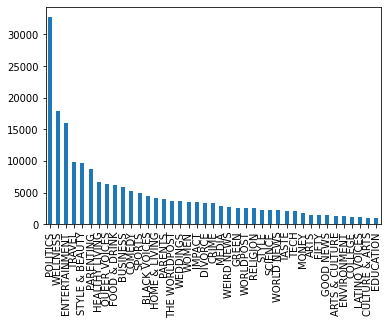

In [14]:
data['category'].value_counts().plot(kind='bar')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


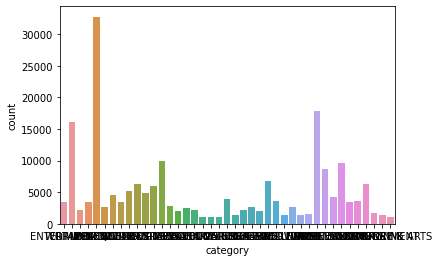

In [15]:
sns.countplot(data['category'])

In [16]:
data['category'].unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

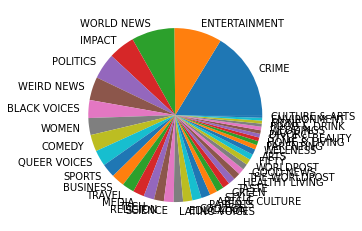

In [17]:
plt.pie(data['category'].value_counts() , labels=data['category'].unique())
plt.show()

- Shape Of data

In [18]:
data.shape

(200853, 2)

- Number Of categories

In [19]:
len(data['category'].unique())

41

- Columns Of Data

In [20]:
data.columns

Index(['category', 'text'], dtype='object')

## Cleaning & Preprocessing

In [21]:
data.duplicated().unique().tolist()

[False, True]

In [22]:
data.drop_duplicates(inplace=True)

In [23]:
data.duplicated().unique().tolist()

[False]

In [24]:
data

,category,text
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M..."
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...


In [25]:
data.iloc[20].tolist()

['WEIRD NEWS',
 "Weird Father's Day Gifts Your Dad Doesn't Know He Wants (But He Does) Why buy a boring tie when you can give him testicle plush toys?"]

In [26]:
data.iloc[200].tolist()

['POLITICS',
 'Arizona GOP Congressional Candidate Compares Abortion To Holocaust “The callousness that our country has for life is very disturbing," GOP candidate Wendy Rogers said.']

In [27]:
def replace_numbers(text):
    return re.sub(r'\d+', '', text)
data['Processed'] =  data['text'].apply(lambda x: replace_numbers(x))

In [28]:
data['Processed'].apply(lambda x: re.findall('\S+@\S+',x)).any()

True

In [29]:
data['Processed']=data['Processed'].apply(lambda x: re.sub('\S+@\S+',' ',x))

In [30]:
data['Processed'].apply(lambda x: re.findall(r'http\S+',x)).any()

True

In [31]:
data['Processed']=data['Processed'].apply(lambda x: re.sub(r'http\S+',' ',x))

In [32]:
data['Processed'].apply(lambda x: re.findall(r'http\S+',x)).any()

False

In [33]:
data['Processed'] = data['Processed'] .apply(lambda x: x.lower())

In [34]:
data['Processed'] = data['Processed'] .apply(lambda x : re.sub(r'[^A-Za-z0-9]', ' ', x))
data['Processed'] 

0         there were  mass shootings in texas last week ...
1         will smith joins diplo and nicky jam for the  ...
2         hugh grant marries for the first time at age  ...
3         jim carrey blasts  castrato  adam schiff and d...
4         julianna margulies uses donald trump poop bags...
                                ...                        
200848    rim ceo thorsten heins   significant  plans fo...
200849    maria sharapova stunned by victoria azarenka i...
200850    giants over patriots  jets over colts among  m...
200851    aldon smith arrested  ers linebacker busted fo...
200852    dwight howard rips teammates after magic loss ...
Name: Processed, Length: 200383, dtype: object

In [35]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
data['Processed'] = data['Processed'].apply(lambda x:remove_punctuation(x))

In [36]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
stop_words=stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [38]:
data['Processed'] =data['Processed'].apply(lambda x :[ word for word in x.split() if word not in stop_words])

In [39]:
data['Processed']

0         [mass, shootings, texas, last, week, tv, left,...
1         [smith, joins, diplo, nicky, jam, world, cup, ...
2         [hugh, grant, marries, first, time, age, actor...
3         [jim, carrey, blasts, castrato, adam, schiff, ...
4         [julianna, margulies, uses, donald, trump, poo...
                                ...                        
200848    [rim, ceo, thorsten, heins, significant, plans...
200849    [maria, sharapova, stunned, victoria, azarenka...
200850    [giants, patriots, jets, colts, among, improba...
200851    [aldon, smith, arrested, ers, linebacker, bust...
200852    [dwight, howard, rips, teammates, magic, loss,...
Name: Processed, Length: 200383, dtype: object

In [40]:
porter_stemmer = PorterStemmer()
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text
data['Processed'] = data['Processed'] .apply(lambda x: stemming(x))

In [41]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [42]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
data['Processed'] = data['Processed'].apply(lambda x:lemmatizer(x))

In [43]:
data

,category,text,Processed
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,"[mass, shoot, texa, last, week, tv, left, husb..."
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,"[smith, join, diplo, nicki, jam, world, cup, o..."
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,"[hugh, grant, marri, first, time, age, actor, ..."
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"[jim, carrey, blast, castrato, adam, schiff, d..."
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"[julianna, marguli, use, donald, trump, poop, ..."
...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"[rim, ceo, thorsten, hein, signific, plan, bla..."
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,"[maria, sharapova, stun, victoria, azarenka, a..."
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...","[giant, patriot, jet, colt, among, improb, sup..."
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,"[aldon, smith, arrest, er, lineback, bust, duo..."


In [44]:
data['Processed'] = data['Processed'].apply(lambda x: ' '.join(x))

In [45]:
data

,category,text,Processed
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,mass shoot texa last week tv left husband kill...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicki jam world cup offici so...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,hugh grant marri first time age actor longtim ...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,julianna marguli use donald trump poop bag pic...
...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,rim ceo thorsten hein signific plan blackberri...
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,maria sharapova stun victoria azarenka austral...
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",giant patriot jet colt among improb super bowl...
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,aldon smith arrest er lineback bust duo correc...


## Modelling

In [46]:
from sklearn import preprocessing
labelEn = preprocessing.LabelEncoder()
data['category'] = labelEn.fit_transform(data['category'])

In [47]:
data['category']

0          6
1         10
2         10
3         10
4         10
          ..
200848    32
200849    28
200850    28
200851    28
200852    28
Name: category, Length: 200383, dtype: int64

In [48]:
from sklearn.model_selection import train_test_split
Features= data['Processed']
labels = data['category']
X_train, X_test, y_train, y_test = train_test_split(Features, labels, shuffle=True, test_size=0.2,random_state=42)

In [49]:
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [50]:
y_train

46195     16
126849    37
108737    10
42451     24
21649     24
          ..
120069    12
103842    16
132153    22
147120    17
122158    40
Name: category, Length: 160306, dtype: int64

In [51]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [52]:
y_test

126226    13
106160    38
4752      24
112205    29
164327     3
          ..
20287     25
149066    32
118956    25
125609    37
98774     27
Name: category, Length: 40077, dtype: int64

In [53]:
test_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [54]:
len(y_test.unique())

41

In [55]:
vocab_size = 20000 
max_length = 41
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [56]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [57]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [58]:
embedding_dim = 16
lstm_dim = 32

In [68]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(lstm_dim),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(41, activation='softmax')
])

In [102]:
# model_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## I used AUC instead of accuracy because Data is imbalanced

In [69]:
model_lstm.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=losses.categorical_crossentropy,
    metrics=[keras.metrics.AUC()]
)

In [70]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 16)            320000    
                                                                 
 lstm (LSTM)                 (None, 32)                6272      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

In [71]:
history_lstm = model_lstm.fit(X_train_pad, train_labels, epochs=5, validation_data=(X_test_pad, test_labels))

Epoch 1/5
5010/5010 [==============================] - 49s 9ms/step - loss: 3.3458 - auc_1: 0.7161 - val_loss: 3.1819 - val_auc_1: 0.7593
Epoch 2/5
5010/5010 [==============================] - 41s 8ms/step - loss: 3.0083 - auc_1: 0.7873 - val_loss: 3.7500 - val_auc_1: 0.7046
Epoch 3/5
5010/5010 [==============================] - 42s 8ms/step - loss: 2.8506 - auc_1: 0.8194 - val_loss: 3.9049 - val_auc_1: 0.7412
Epoch 4/5
5010/5010 [==============================] - 42s 8ms/step - loss: 2.7758 - auc_1: 0.8335 - val_loss: 5.5177 - val_auc_1: 0.6863
Epoch 5/5
5010/5010 [==============================] - 41s 8ms/step - loss: 2.7302 - auc_1: 0.8419 - val_loss: 3.8211 - val_auc_1: 0.7674


## Enhancement

In [72]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(lstm_dim)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(41, activation='softmax')
])

In [73]:
model_gru.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=losses.categorical_crossentropy,
    metrics=[keras.metrics.AUC()]
)

In [74]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 41, 16)            320000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [75]:
history_gru= model_gru.fit(X_train_pad, train_labels, epochs=5, validation_data=(X_test_pad, test_labels))

Epoch 1/5
5010/5010 [==============================] - 63s 12ms/step - loss: 3.3452 - auc_2: 0.7152 - val_loss: 3.0398 - val_auc_2: 0.7776
Epoch 2/5
5010/5010 [==============================] - 59s 12ms/step - loss: 2.9635 - auc_2: 0.7958 - val_loss: 4.0193 - val_auc_2: 0.7090
Epoch 3/5
5010/5010 [==============================] - 57s 11ms/step - loss: 2.7383 - auc_2: 0.8348 - val_loss: 3.0496 - val_auc_2: 0.7863
Epoch 4/5
5010/5010 [==============================] - 58s 12ms/step - loss: 2.5728 - auc_2: 0.8581 - val_loss: 2.6919 - val_auc_2: 0.8381
Epoch 5/5
5010/5010 [==============================] - 57s 11ms/step - loss: 2.4612 - auc_2: 0.8723 - val_loss: 2.4561 - val_auc_2: 0.8682


## Another Enhancement

In [59]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,64),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True,recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax')   
])

In [60]:
model.compile(optimizer= Adam(lr=0.00005),
              loss= keras.losses.categorical_crossentropy,
              metrics= [keras.metrics.AUC()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280064   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49920     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 41)                2

In [62]:
history = model.fit(X_train_pad, train_labels, epochs=2, validation_data=(X_test_pad, test_labels))

Epoch 1/2
5010/5010 [==============================] - 1435s 285ms/step - loss: 3.1360 - auc: 0.7618 - val_loss: 2.8528 - val_auc: 0.8188
Epoch 2/2
5010/5010 [==============================] - 1344s 268ms/step - loss: 2.7500 - auc: 0.8342 - val_loss: 2.5873 - val_auc: 0.8560


## Final Results and Conclusion

### Evaluation of model_lstm

In [76]:
model_lstm.evaluate(X_test_pad, test_labels)

1253/1253 [==============================] - 5s 4ms/step - loss: 3.8211 - auc_1: 0.7674


[3.821058988571167, 0.7673963308334351]

In [77]:
auc = history_lstm.history['auc_1']
val_auc = history_lstm.history['val_auc_1']
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

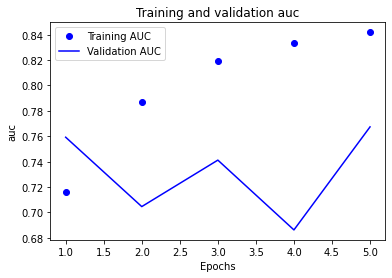

In [78]:
epochs = range(1, len(auc) + 1)
plt.plot(epochs, auc, 'bo', label = 'Training AUC')
plt.plot(epochs, val_auc, 'b', label = 'Validation AUC')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.show()

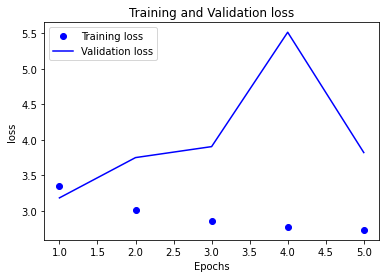

In [79]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [156]:
# y_pred = model_lstm.predict(X_test_pad)

In [157]:
# y_pred_thresh = np.array(y_pred>= 0.5, dtype='int')

In [158]:
# from sklearn.metrics import classification_report
# print(classification_report(test_labels,y_pred_thresh))

### Evaluation of model_gru

In [80]:
model_gru.evaluate(X_test_pad, test_labels)

1253/1253 [==============================] - 6s 5ms/step - loss: 2.4561 - auc_2: 0.8682


[2.4561269283294678, 0.8681889176368713]

In [81]:
auc = history_gru.history['auc_2']
val_auc = history_gru.history['val_auc_2']
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']

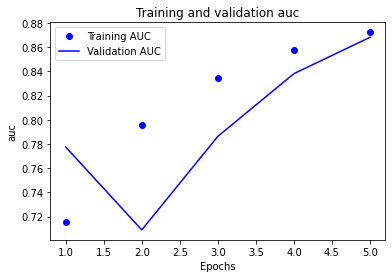

In [82]:
epochs = range(1, len(auc) + 1)
plt.plot(epochs, auc, 'bo', label = 'Training AUC')
plt.plot(epochs, val_auc, 'b', label = 'Validation AUC')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.show()

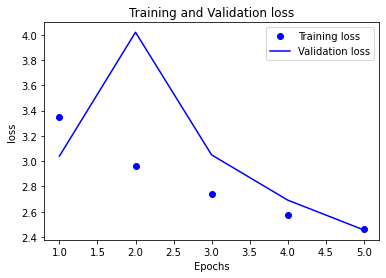

In [83]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [162]:
# y_pred = model_gru.predict(X_test_pad)

In [163]:
# y_pred_thresh = np.array(y_pred>= 0.5, dtype='int')

In [164]:
# from sklearn.metrics import classification_report
# print(classification_report(test_labels,y_pred_thresh))

### Evaluation of model

In [63]:
model.evaluate(X_test_pad, test_labels)

1253/1253 [==============================] - 38s 31ms/step - loss: 2.5873 - auc: 0.8560


[2.5872762203216553, 0.8559631109237671]

In [64]:
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

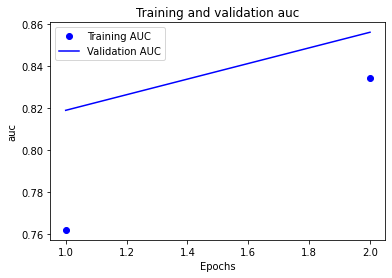

In [65]:
epochs = range(1, len(auc) + 1)
plt.plot(epochs, auc, 'bo', label = 'Training AUC')
plt.plot(epochs, val_auc, 'b', label = 'Validation AUC')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.show()

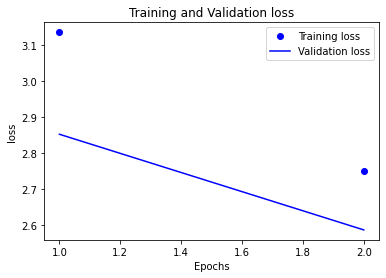

In [67]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()